## Hyperparameter tuning with Optuna

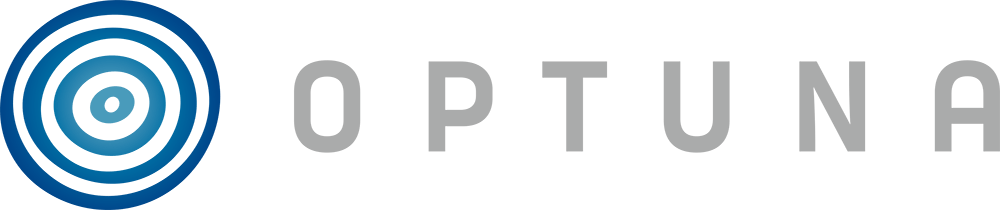

In [ ]:
%%capture

!apt-get update && apt-get install -y xvfb
!pip install swig
!pip install gym[box2d]==0.23.1 pytorch-lightning==1.6.0 pyvirtualdisplay optuna==2.7.0

#### Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [36]:
import copy
import statistics
import gym
import torch
import optuna

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW


from lightning.pytorch import LightningModule, Trainer
#earlier it was 
# from pytorch_lightning import LightningModule, Trainer
#it raised the following error
# https://github.com/optuna/optuna/issues/4689

from gym.wrappers import RecordVideo, RecordEpisodeStatistics

from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
# from pytorch_lightning.loggers import TensorBoardLogger

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [18]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [19]:
class DQN(nn.Module):
    def __init__(self, hidden_size, obs_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),           
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        return self.net(x.float())

#### Create the policy

In [20]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
      action = env.action_space.sample()
  else:
      state = torch.tensor([state]).to(device)
      q_values = net(state)
      _, action = torch.max(q_values, dim=1)
      action = int(action.item())
  return action

#### Create the replay buffer

In [21]:
Experience = namedtuple(
    "Experience",
    field_names=["state", "action", "reward", "done", "new_state"],
)

In [37]:
class ReplayBuffer:

    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):

        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*(self.buffer[idx] for idx in indices))

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=bool),
            np.array(next_states),
        )

In [38]:
class RLDataset(IterableDataset):

    def __init__(self, buffer, sample_size=200):
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self):
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

#### Create the environment

In [24]:
def create_environment(name):
  env = gym.make(name)
  env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
  env = RecordEpisodeStatistics(env)
  return env

#### Create the test/sampling function

In [25]:
  @torch.no_grad()
  def play_episode(env, q_net, buffer, policy=None, epsilon=0.):
      obs = env.reset()
      done = False

      while not done:
        if policy:
          action = policy(obs, env, q_net, epsilon=epsilon)
        else:
          action = env.action_space.sample()
          
        next_obs, reward, done, info = env.step(action)
        exp = Experience(obs, action, reward, done, next_obs)
        buffer.append(exp)
        obs = next_obs

#### Create the Deep Q-Learning algorithm

In [44]:
class DeepQLearning(LightningModule):

  def __init__(self, env_name, policy=epsilon_greedy, sample_fn=play_episode, 
               capacity=100_000, batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, 
               loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15, 
               eps_last_episode=100, samples_per_epoch=10_000, sync_rate=10):

    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape[0]
    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size, n_actions).to(device)
    self.target_q_net = copy.deepcopy(self.q_net)
    self.policy = policy

    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:

      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.hparams.sample_fn(self.env, self.q_net, self.buffer, epsilon=self.hparams.eps_start)
  
  def forward(self, x):
    output = self.q_net(x)
    return output

  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
    return [q_net_optimizer]

  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size,
    )
    return dataloader

  def training_step(self, batch, batch_idx):

    states, actions, rewards, dones, next_states = batch
    actions=actions.long()#this line was added because of an error in the gather function below
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)
    state_action_values = self.q_net(states).gather(1, actions)

    with torch.no_grad():
      next_state_values, _ = self.target_q_net(next_states).max(dim=1, keepdim=True)
      next_state_values[dones] = 0.0
    
    expected_state_action_values = rewards + self.hparams.gamma * next_state_values

    loss = self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/MSE Loss', loss, on_step=False, on_epoch=True)
    return loss


  def on_train_epoch_end(self):

    epsilon = max(
        self.hparams.eps_end,
        self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )

    self.hparams.sample_fn(self.env, self.q_net, self.buffer, policy=self.policy, epsilon=epsilon)

    self.log("episode/Return", self.env.return_queue[-1])
    if self.current_epoch == 199:
      returns = list(self.env.return_queue)
      self.log("hp_metric", statistics.mean(returns))#we are taking the mean of the return over 200 epsiodes for a certain set of parameters because return of each episode can vary greatly
      #in comparison to each other
      #this is the value that the obejctive function will return and study object will monitor
    

    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

#### Create the objective function

In [45]:
def objective(trial):#trial is the object which we will use to select the parameters to test
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)#text in the "" is the name given to the parameter, the second and third parameter are the ranges
  #between which a value will be selected, we also give it logarithmic scale because otherwise it will spend a lot of time searching for smaller values within this range 
  gamma = trial.suggest_float("gamma", 0.0, 1.0)
  hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
  eps_end = trial.suggest_float("eps_end", 0.0, 0.3)

  algo = DeepQLearning(
      'LunarLander-v2',
      lr=lr,
      gamma=gamma,
      hidden_size=hidden_size,
      eps_end=eps_end
  )

  callback = PyTorchLightningPruningCallback(trial, monitor="episode/Return")

  # logger = TensorBoardLogger("tb_logs", name="my_model")

  trainer = Trainer(
    #   gpus=num_gpus, 
      max_epochs=200,
      # track_grad_norm=2,
      callbacks=[callback],
      # logger=logger
  )

  hyperparameters = dict(
      lr=lr, 
      gamma=gamma, 
      hidden_size=hidden_size,
      eps_end=eps_end
  )
  
  trainer.logger.log_hyperparams(hyperparameters)
  trainer.fit(algo)

  return trainer.callback_metrics["episode/Return"].item()

#### Create the optimization study

In [46]:
pruner = optuna.pruners.SuccessiveHalvingPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)#direction="maximise" is telling the function that we wish to maximize the value which we are monitoring inside the objective function
#which is the running average of the returns

[I 2024-07-02 08:06:46,543] A new study created in memory with name: no-name-1a5545f0-db47-433d-b795-d943950ff53c


#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Run the hyperparameter search

In [47]:
study.optimize(objective, n_trials=20)

0 samples in experience buffer. Filling...
96 samples in experience buffer. Filling...
156 samples in experience buffer. Filling...
243 samples in experience buffer. Filling...
374 samples in experience buffer. Filling...
480 samples in experience buffer. Filling...
578 samples in experience buffer. Filling...
691 samples in experience buffer. Filling...
819 samples in experience buffer. Filling...
909 samples in experience buffer. Filling...
1000 samples in experience buffer. Filling...
1099 samples in experience buffer. Filling...
1185 samples in experience buffer. Filling...
1312 samples in experience buffer. Filling...
1415 samples in experience buffer. Filling...
1541 samples in experience buffer. Filling...
1622 samples in experience buffer. Filling...
1734 samples in experience buffer. Filling...
1797 samples in experience buffer. Filling...
1904 samples in experience buffer. Filling...
1975 samples in experience buffer. Filling...
2099 samples in experience buffer. Filling...
2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9423 samples in experience buffer. Filling...
9508 samples in experience buffer. Filling...
9636 samples in experience buffer. Filling...
9716 samples in experience buffer. Filling...
9789 samples in experience buffer. Filling...
9902 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 69.1 K | train
1 | target_q_net | DQN  | 69.1 K | train
----------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
0.553     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\haadi\AppData\Local\Temp\ipykernel_24364\1507904788.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state]).to(device)
`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:10:47,971] Trial 0 finished with value: -241.96539306640625 and parameters: {'lr': 0.0017503780778528849, 'gamma': 0.7781599075447769, 'hidden_size': 256, 'eps_end': 0.10772209039861792}. Best is trial 0 with value: -241.96539306640625.


0 samples in experience buffer. Filling...
83 samples in experience buffer. Filling...
149 samples in experience buffer. Filling...
238 samples in experience buffer. Filling...
317 samples in experience buffer. Filling...
420 samples in experience buffer. Filling...
552 samples in experience buffer. Filling...
675 samples in experience buffer. Filling...
747 samples in experience buffer. Filling...
831 samples in experience buffer. Filling...
898 samples in experience buffer. Filling...
991 samples in experience buffer. Filling...
1088 samples in experience buffer. Filling...
1165 samples in experience buffer. Filling...
1287 samples in experience buffer. Filling...
1372 samples in experience buffer. Filling...
1437 samples in experience buffer. Filling...
1520 samples in experience buffer. Filling...
1589 samples in experience buffer. Filling...
1699 samples in experience buffer. Filling...
1805 samples in experience buffer. Filling...
1903 samples in experience buffer. Filling...
198

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9277 samples in experience buffer. Filling...
9376 samples in experience buffer. Filling...
9487 samples in experience buffer. Filling...
9564 samples in experience buffer. Filling...
9682 samples in experience buffer. Filling...
9754 samples in experience buffer. Filling...
9854 samples in experience buffer. Filling...
9913 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:13:51,831] Trial 1 finished with value: -260.06988525390625 and parameters: {'lr': 0.00011680536902854591, 'gamma': 0.32221493974685844, 'hidden_size': 128, 'eps_end': 0.2272240674608202}. Best is trial 0 with value: -241.96539306640625.


0 samples in experience buffer. Filling...
81 samples in experience buffer. Filling...
151 samples in experience buffer. Filling...
228 samples in experience buffer. Filling...
341 samples in experience buffer. Filling...
409 samples in experience buffer. Filling...
499 samples in experience buffer. Filling...
597 samples in experience buffer. Filling...
696 samples in experience buffer. Filling...
775 samples in experience buffer. Filling...
866 samples in experience buffer. Filling...
960 samples in experience buffer. Filling...
1078 samples in experience buffer. Filling...
1162 samples in experience buffer. Filling...
1273 samples in experience buffer. Filling...
1361 samples in experience buffer. Filling...
1459 samples in experience buffer. Filling...
1579 samples in experience buffer. Filling...
1654 samples in experience buffer. Filling...
1768 samples in experience buffer. Filling...
1874 samples in experience buffer. Filling...
1966 samples in experience buffer. Filling...
203

GPU available: True (cuda), used: True


8982 samples in experience buffer. Filling...
9072 samples in experience buffer. Filling...
9158 samples in experience buffer. Filling...
9288 samples in experience buffer. Filling...
9395 samples in experience buffer. Filling...
9498 samples in experience buffer. Filling...
9571 samples in experience buffer. Filling...
9659 samples in experience buffer. Filling...
9732 samples in experience buffer. Filling...
9809 samples in experience buffer. Filling...
9908 samples in experience buffer. Filling...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 69.1 K | train
1 | target_q_net | DQN  | 69.1 K | train
----------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
0.553     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:19:28,159] Trial 2 finished with value: -69.89277648925781 and parameters: {'lr': 0.001105918756644981, 'gamma': 0.9027112477363138, 'hidden_size': 256, 'eps_end': 0.06243170170120603}. Best is trial 2 with value: -69.89277648925781.


0 samples in experience buffer. Filling...
77 samples in experience buffer. Filling...
152 samples in experience buffer. Filling...
251 samples in experience buffer. Filling...
365 samples in experience buffer. Filling...
474 samples in experience buffer. Filling...
567 samples in experience buffer. Filling...
686 samples in experience buffer. Filling...
786 samples in experience buffer. Filling...
909 samples in experience buffer. Filling...
1035 samples in experience buffer. Filling...
1125 samples in experience buffer. Filling...
1216 samples in experience buffer. Filling...
1296 samples in experience buffer. Filling...
1353 samples in experience buffer. Filling...
1427 samples in experience buffer. Filling...
1508 samples in experience buffer. Filling...
1575 samples in experience buffer. Filling...
1655 samples in experience buffer. Filling...
1730 samples in experience buffer. Filling...
1846 samples in experience buffer. Filling...
1929 samples in experience buffer. Filling...
2

GPU available: True (cuda), used: True


9106 samples in experience buffer. Filling...
9189 samples in experience buffer. Filling...
9247 samples in experience buffer. Filling...
9326 samples in experience buffer. Filling...
9424 samples in experience buffer. Filling...
9507 samples in experience buffer. Filling...
9610 samples in experience buffer. Filling...
9704 samples in experience buffer. Filling...
9811 samples in experience buffer. Filling...
9930 samples in experience buffer. Filling...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:22:41,821] Trial 3 finished with value: -93.09330749511719 and parameters: {'lr': 0.0026668941298903966, 'gamma': 0.359545869105662, 'hidden_size': 128, 'eps_end': 0.22715183732296815}. Best is trial 2 with value: -69.89277648925781.


0 samples in experience buffer. Filling...
76 samples in experience buffer. Filling...
162 samples in experience buffer. Filling...
255 samples in experience buffer. Filling...
337 samples in experience buffer. Filling...
469 samples in experience buffer. Filling...
583 samples in experience buffer. Filling...
703 samples in experience buffer. Filling...
800 samples in experience buffer. Filling...
902 samples in experience buffer. Filling...
996 samples in experience buffer. Filling...
1092 samples in experience buffer. Filling...
1211 samples in experience buffer. Filling...
1291 samples in experience buffer. Filling...
1407 samples in experience buffer. Filling...
1495 samples in experience buffer. Filling...
1558 samples in experience buffer. Filling...
1668 samples in experience buffer. Filling...
1753 samples in experience buffer. Filling...
1843 samples in experience buffer. Filling...
1965 samples in experience buffer. Filling...
2053 samples in experience buffer. Filling...
21

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9353 samples in experience buffer. Filling...
9442 samples in experience buffer. Filling...
9562 samples in experience buffer. Filling...
9674 samples in experience buffer. Filling...
9830 samples in experience buffer. Filling...
9906 samples in experience buffer. Filling...
9996 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 69.1 K | train
1 | target_q_net | DQN  | 69.1 K | train
----------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
0.553     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:26:04,768] Trial 4 finished with value: -179.56101989746094 and parameters: {'lr': 0.0023922485145384358, 'gamma': 0.6302222399546862, 'hidden_size': 256, 'eps_end': 0.06673136205305802}. Best is trial 2 with value: -69.89277648925781.


0 samples in experience buffer. Filling...
98 samples in experience buffer. Filling...
156 samples in experience buffer. Filling...
229 samples in experience buffer. Filling...
331 samples in experience buffer. Filling...
402 samples in experience buffer. Filling...
469 samples in experience buffer. Filling...
546 samples in experience buffer. Filling...
679 samples in experience buffer. Filling...
747 samples in experience buffer. Filling...
861 samples in experience buffer. Filling...
1005 samples in experience buffer. Filling...
1130 samples in experience buffer. Filling...
1238 samples in experience buffer. Filling...
1330 samples in experience buffer. Filling...
1455 samples in experience buffer. Filling...
1537 samples in experience buffer. Filling...
1637 samples in experience buffer. Filling...
1738 samples in experience buffer. Filling...
1835 samples in experience buffer. Filling...
1898 samples in experience buffer. Filling...
1982 samples in experience buffer. Filling...
20

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9436 samples in experience buffer. Filling...
9537 samples in experience buffer. Filling...
9645 samples in experience buffer. Filling...
9730 samples in experience buffer. Filling...
9812 samples in experience buffer. Filling...
9937 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 5.0 K  | train
1 | target_q_net | DQN  | 5.0 K  | train
----------------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:29:21,128] Trial 5 finished with value: -28.610305786132812 and parameters: {'lr': 0.0601675714960212, 'gamma': 0.18866281424771947, 'hidden_size': 64, 'eps_end': 0.10430826402327686}. Best is trial 5 with value: -28.610305786132812.


0 samples in experience buffer. Filling...
73 samples in experience buffer. Filling...
158 samples in experience buffer. Filling...
228 samples in experience buffer. Filling...
315 samples in experience buffer. Filling...
432 samples in experience buffer. Filling...
553 samples in experience buffer. Filling...
687 samples in experience buffer. Filling...
785 samples in experience buffer. Filling...
891 samples in experience buffer. Filling...
969 samples in experience buffer. Filling...
1051 samples in experience buffer. Filling...
1140 samples in experience buffer. Filling...
1206 samples in experience buffer. Filling...
1281 samples in experience buffer. Filling...
1395 samples in experience buffer. Filling...
1482 samples in experience buffer. Filling...
1572 samples in experience buffer. Filling...
1633 samples in experience buffer. Filling...
1697 samples in experience buffer. Filling...
1761 samples in experience buffer. Filling...
1867 samples in experience buffer. Filling...
19

GPU available: True (cuda), used: True


9334 samples in experience buffer. Filling...
9421 samples in experience buffer. Filling...
9524 samples in experience buffer. Filling...
9623 samples in experience buffer. Filling...
9681 samples in experience buffer. Filling...
9762 samples in experience buffer. Filling...
9823 samples in experience buffer. Filling...
9910 samples in experience buffer. Filling...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:32:04,041] Trial 6 finished with value: -9.713607788085938 and parameters: {'lr': 0.00010628792889415254, 'gamma': 0.34208771766571366, 'hidden_size': 128, 'eps_end': 0.2799671764234091}. Best is trial 6 with value: -9.713607788085938.


0 samples in experience buffer. Filling...
73 samples in experience buffer. Filling...
147 samples in experience buffer. Filling...
226 samples in experience buffer. Filling...
319 samples in experience buffer. Filling...
402 samples in experience buffer. Filling...
477 samples in experience buffer. Filling...
558 samples in experience buffer. Filling...
647 samples in experience buffer. Filling...
743 samples in experience buffer. Filling...
828 samples in experience buffer. Filling...
923 samples in experience buffer. Filling...
993 samples in experience buffer. Filling...
1069 samples in experience buffer. Filling...
1141 samples in experience buffer. Filling...
1214 samples in experience buffer. Filling...
1286 samples in experience buffer. Filling...
1357 samples in experience buffer. Filling...
1437 samples in experience buffer. Filling...
1533 samples in experience buffer. Filling...
1596 samples in experience buffer. Filling...
1710 samples in experience buffer. Filling...
1804

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9406 samples in experience buffer. Filling...
9491 samples in experience buffer. Filling...
9575 samples in experience buffer. Filling...
9649 samples in experience buffer. Filling...
9736 samples in experience buffer. Filling...
9825 samples in experience buffer. Filling...
9908 samples in experience buffer. Filling...
9988 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:35:24,447] Trial 7 finished with value: -196.81130981445312 and parameters: {'lr': 0.00026026619042916895, 'gamma': 0.48168220788305627, 'hidden_size': 128, 'eps_end': 0.043055372591207175}. Best is trial 6 with value: -9.713607788085938.


0 samples in experience buffer. Filling...
93 samples in experience buffer. Filling...
184 samples in experience buffer. Filling...
282 samples in experience buffer. Filling...
371 samples in experience buffer. Filling...
445 samples in experience buffer. Filling...
538 samples in experience buffer. Filling...
601 samples in experience buffer. Filling...
670 samples in experience buffer. Filling...
750 samples in experience buffer. Filling...
856 samples in experience buffer. Filling...
943 samples in experience buffer. Filling...
1007 samples in experience buffer. Filling...
1114 samples in experience buffer. Filling...
1189 samples in experience buffer. Filling...
1262 samples in experience buffer. Filling...
1334 samples in experience buffer. Filling...
1422 samples in experience buffer. Filling...
1516 samples in experience buffer. Filling...
1625 samples in experience buffer. Filling...
1733 samples in experience buffer. Filling...
1843 samples in experience buffer. Filling...
193

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9352 samples in experience buffer. Filling...
9431 samples in experience buffer. Filling...
9519 samples in experience buffer. Filling...
9613 samples in experience buffer. Filling...
9679 samples in experience buffer. Filling...
9742 samples in experience buffer. Filling...
9802 samples in experience buffer. Filling...
9903 samples in experience buffer. Filling...
9975 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 1.5 K  | train
1 | target_q_net | DQN  | 1.5 K  | train
----------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:38:30,332] Trial 8 finished with value: -45.47260665893555 and parameters: {'lr': 0.0015243352982419786, 'gamma': 0.18713698596785566, 'hidden_size': 32, 'eps_end': 0.20775113729534253}. Best is trial 6 with value: -9.713607788085938.


0 samples in experience buffer. Filling...
89 samples in experience buffer. Filling...
184 samples in experience buffer. Filling...
280 samples in experience buffer. Filling...
379 samples in experience buffer. Filling...
461 samples in experience buffer. Filling...
552 samples in experience buffer. Filling...
630 samples in experience buffer. Filling...
694 samples in experience buffer. Filling...
795 samples in experience buffer. Filling...
896 samples in experience buffer. Filling...
990 samples in experience buffer. Filling...
1089 samples in experience buffer. Filling...
1153 samples in experience buffer. Filling...
1288 samples in experience buffer. Filling...
1398 samples in experience buffer. Filling...
1456 samples in experience buffer. Filling...
1575 samples in experience buffer. Filling...
1631 samples in experience buffer. Filling...
1697 samples in experience buffer. Filling...
1795 samples in experience buffer. Filling...
1859 samples in experience buffer. Filling...
194

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9306 samples in experience buffer. Filling...
9425 samples in experience buffer. Filling...
9493 samples in experience buffer. Filling...
9612 samples in experience buffer. Filling...
9729 samples in experience buffer. Filling...
9798 samples in experience buffer. Filling...
9901 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:41:30,348] Trial 9 finished with value: 252.13320922851562 and parameters: {'lr': 0.0036502063949420765, 'gamma': 0.6207765698639972, 'hidden_size': 128, 'eps_end': 0.08699195823968492}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
65 samples in experience buffer. Filling...
127 samples in experience buffer. Filling...
223 samples in experience buffer. Filling...
316 samples in experience buffer. Filling...
451 samples in experience buffer. Filling...
576 samples in experience buffer. Filling...
630 samples in experience buffer. Filling...
713 samples in experience buffer. Filling...
792 samples in experience buffer. Filling...
898 samples in experience buffer. Filling...
999 samples in experience buffer. Filling...
1136 samples in experience buffer. Filling...
1252 samples in experience buffer. Filling...
1323 samples in experience buffer. Filling...
1450 samples in experience buffer. Filling...
1548 samples in experience buffer. Filling...
1609 samples in experience buffer. Filling...
1704 samples in experience buffer. Filling...
1785 samples in experience buffer. Filling...
1887 samples in experience buffer. Filling...
2019 samples in experience buffer. Filling...
210

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9614 samples in experience buffer. Filling...
9686 samples in experience buffer. Filling...
9802 samples in experience buffer. Filling...
9875 samples in experience buffer. Filling...
9957 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 5.0 K  | train
1 | target_q_net | DQN  | 5.0 K  | train
----------------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:44:52,633] Trial 10 finished with value: -174.33912658691406 and parameters: {'lr': 0.01967392966320188, 'gamma': 0.606155768840539, 'hidden_size': 64, 'eps_end': 0.006856685260701434}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
104 samples in experience buffer. Filling...
194 samples in experience buffer. Filling...
312 samples in experience buffer. Filling...
374 samples in experience buffer. Filling...
446 samples in experience buffer. Filling...
544 samples in experience buffer. Filling...
615 samples in experience buffer. Filling...
692 samples in experience buffer. Filling...
822 samples in experience buffer. Filling...
912 samples in experience buffer. Filling...
982 samples in experience buffer. Filling...
1078 samples in experience buffer. Filling...
1159 samples in experience buffer. Filling...
1236 samples in experience buffer. Filling...
1347 samples in experience buffer. Filling...
1439 samples in experience buffer. Filling...
1560 samples in experience buffer. Filling...
1652 samples in experience buffer. Filling...
1738 samples in experience buffer. Filling...
1799 samples in experience buffer. Filling...
1912 samples in experience buffer. Filling...
19

GPU available: True (cuda), used: True


9067 samples in experience buffer. Filling...
9184 samples in experience buffer. Filling...
9271 samples in experience buffer. Filling...
9371 samples in experience buffer. Filling...
9430 samples in experience buffer. Filling...
9519 samples in experience buffer. Filling...
9613 samples in experience buffer. Filling...
9731 samples in experience buffer. Filling...
9853 samples in experience buffer. Filling...
9952 samples in experience buffer. Filling...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:47:40,095] Trial 11 finished with value: -46.776893615722656 and parameters: {'lr': 1.8064002272526133e-05, 'gamma': 0.07181682210634144, 'hidden_size': 128, 'eps_end': 0.28795300673604457}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
134 samples in experience buffer. Filling...
205 samples in experience buffer. Filling...
283 samples in experience buffer. Filling...
366 samples in experience buffer. Filling...
490 samples in experience buffer. Filling...
560 samples in experience buffer. Filling...
639 samples in experience buffer. Filling...
734 samples in experience buffer. Filling...
835 samples in experience buffer. Filling...
914 samples in experience buffer. Filling...
979 samples in experience buffer. Filling...
1090 samples in experience buffer. Filling...
1201 samples in experience buffer. Filling...
1300 samples in experience buffer. Filling...
1396 samples in experience buffer. Filling...
1515 samples in experience buffer. Filling...
1574 samples in experience buffer. Filling...
1681 samples in experience buffer. Filling...
1775 samples in experience buffer. Filling...
1867 samples in experience buffer. Filling...
1958 samples in experience buffer. Filling...
20

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9489 samples in experience buffer. Filling...
9620 samples in experience buffer. Filling...
9717 samples in experience buffer. Filling...
9832 samples in experience buffer. Filling...
9953 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:50:59,104] Trial 12 finished with value: 142.99990844726562 and parameters: {'lr': 0.00010542725867673657, 'gamma': 0.49336346275537785, 'hidden_size': 128, 'eps_end': 0.15807533418906972}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
71 samples in experience buffer. Filling...
189 samples in experience buffer. Filling...
273 samples in experience buffer. Filling...
360 samples in experience buffer. Filling...
452 samples in experience buffer. Filling...
549 samples in experience buffer. Filling...
656 samples in experience buffer. Filling...
716 samples in experience buffer. Filling...
841 samples in experience buffer. Filling...
907 samples in experience buffer. Filling...
990 samples in experience buffer. Filling...
1060 samples in experience buffer. Filling...
1163 samples in experience buffer. Filling...
1263 samples in experience buffer. Filling...
1333 samples in experience buffer. Filling...
1428 samples in experience buffer. Filling...
1520 samples in experience buffer. Filling...
1664 samples in experience buffer. Filling...
1763 samples in experience buffer. Filling...
1850 samples in experience buffer. Filling...
1933 samples in experience buffer. Filling...
200

GPU available: True (cuda), used: True


9126 samples in experience buffer. Filling...
9214 samples in experience buffer. Filling...
9288 samples in experience buffer. Filling...
9370 samples in experience buffer. Filling...
9432 samples in experience buffer. Filling...
9516 samples in experience buffer. Filling...
9633 samples in experience buffer. Filling...
9690 samples in experience buffer. Filling...
9756 samples in experience buffer. Filling...
9856 samples in experience buffer. Filling...
9957 samples in experience buffer. Filling...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 1.5 K  | train
1 | target_q_net | DQN  | 1.5 K  | train
----------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:55:03,853] Trial 13 finished with value: -32.616188049316406 and parameters: {'lr': 0.014942508430231415, 'gamma': 0.7117141013262079, 'hidden_size': 32, 'eps_end': 0.1450575079501096}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
77 samples in experience buffer. Filling...
147 samples in experience buffer. Filling...
213 samples in experience buffer. Filling...
307 samples in experience buffer. Filling...
423 samples in experience buffer. Filling...
541 samples in experience buffer. Filling...
644 samples in experience buffer. Filling...
730 samples in experience buffer. Filling...
796 samples in experience buffer. Filling...
896 samples in experience buffer. Filling...
962 samples in experience buffer. Filling...
1039 samples in experience buffer. Filling...
1112 samples in experience buffer. Filling...
1209 samples in experience buffer. Filling...
1279 samples in experience buffer. Filling...
1356 samples in experience buffer. Filling...
1430 samples in experience buffer. Filling...
1552 samples in experience buffer. Filling...
1658 samples in experience buffer. Filling...
1781 samples in experience buffer. Filling...
1857 samples in experience buffer. Filling...
195

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 08:57:52,327] Trial 14 finished with value: -50.66516876220703 and parameters: {'lr': 2.352909962855123e-05, 'gamma': 0.5367855145107857, 'hidden_size': 128, 'eps_end': 0.17069579341026087}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
73 samples in experience buffer. Filling...
179 samples in experience buffer. Filling...
258 samples in experience buffer. Filling...
387 samples in experience buffer. Filling...
499 samples in experience buffer. Filling...
569 samples in experience buffer. Filling...
653 samples in experience buffer. Filling...
721 samples in experience buffer. Filling...
792 samples in experience buffer. Filling...
873 samples in experience buffer. Filling...
947 samples in experience buffer. Filling...
1020 samples in experience buffer. Filling...
1088 samples in experience buffer. Filling...
1184 samples in experience buffer. Filling...
1263 samples in experience buffer. Filling...
1351 samples in experience buffer. Filling...
1465 samples in experience buffer. Filling...
1575 samples in experience buffer. Filling...
1684 samples in experience buffer. Filling...
1784 samples in experience buffer. Filling...
1859 samples in experience buffer. Filling...
192

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 09:03:26,970] Trial 15 finished with value: -90.5401611328125 and parameters: {'lr': 0.00032400638091776353, 'gamma': 0.9120063424733793, 'hidden_size': 128, 'eps_end': 0.13540534582189656}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
122 samples in experience buffer. Filling...
207 samples in experience buffer. Filling...
296 samples in experience buffer. Filling...
372 samples in experience buffer. Filling...
458 samples in experience buffer. Filling...
577 samples in experience buffer. Filling...
669 samples in experience buffer. Filling...
800 samples in experience buffer. Filling...
905 samples in experience buffer. Filling...
990 samples in experience buffer. Filling...
1088 samples in experience buffer. Filling...
1200 samples in experience buffer. Filling...
1285 samples in experience buffer. Filling...
1390 samples in experience buffer. Filling...
1459 samples in experience buffer. Filling...
1544 samples in experience buffer. Filling...
1614 samples in experience buffer. Filling...
1682 samples in experience buffer. Filling...
1772 samples in experience buffer. Filling...
1886 samples in experience buffer. Filling...
1995 samples in experience buffer. Filling...
2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9245 samples in experience buffer. Filling...
9328 samples in experience buffer. Filling...
9450 samples in experience buffer. Filling...
9566 samples in experience buffer. Filling...
9664 samples in experience buffer. Filling...
9745 samples in experience buffer. Filling...
9807 samples in experience buffer. Filling...
9900 samples in experience buffer. Filling...
9973 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 09:06:35,807] Trial 16 finished with value: -117.21269226074219 and parameters: {'lr': 0.007435679925556904, 'gamma': 0.4613738088805487, 'hidden_size': 128, 'eps_end': 0.17387336072535675}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
109 samples in experience buffer. Filling...
191 samples in experience buffer. Filling...
293 samples in experience buffer. Filling...
393 samples in experience buffer. Filling...
472 samples in experience buffer. Filling...
577 samples in experience buffer. Filling...
665 samples in experience buffer. Filling...
773 samples in experience buffer. Filling...
867 samples in experience buffer. Filling...
939 samples in experience buffer. Filling...
1072 samples in experience buffer. Filling...
1186 samples in experience buffer. Filling...
1301 samples in experience buffer. Filling...
2301 samples in experience buffer. Filling...
2408 samples in experience buffer. Filling...
2496 samples in experience buffer. Filling...
2619 samples in experience buffer. Filling...
2735 samples in experience buffer. Filling...
2798 samples in experience buffer. Filling...
2914 samples in experience buffer. Filling...
3024 samples in experience buffer. Filling...
3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9420 samples in experience buffer. Filling...
9524 samples in experience buffer. Filling...
9609 samples in experience buffer. Filling...
9669 samples in experience buffer. Filling...
9769 samples in experience buffer. Filling...
9876 samples in experience buffer. Filling...
9967 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 1.5 K  | train
1 | target_q_net | DQN  | 1.5 K  | train
----------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 10:47:25,335] Trial 17 finished with value: -219.07022094726562 and parameters: {'lr': 4.3877528163358176e-05, 'gamma': 0.7944064008909305, 'hidden_size': 32, 'eps_end': 0.09110725805950888}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
86 samples in experience buffer. Filling...
163 samples in experience buffer. Filling...
302 samples in experience buffer. Filling...
397 samples in experience buffer. Filling...
508 samples in experience buffer. Filling...
582 samples in experience buffer. Filling...
644 samples in experience buffer. Filling...
738 samples in experience buffer. Filling...
857 samples in experience buffer. Filling...
1003 samples in experience buffer. Filling...
1093 samples in experience buffer. Filling...
1157 samples in experience buffer. Filling...
1227 samples in experience buffer. Filling...
1297 samples in experience buffer. Filling...
1385 samples in experience buffer. Filling...
1455 samples in experience buffer. Filling...
1559 samples in experience buffer. Filling...
1641 samples in experience buffer. Filling...
1732 samples in experience buffer. Filling...
1824 samples in experience buffer. Filling...
1916 samples in experience buffer. Filling...
1

GPU available: True (cuda), used: True


9274 samples in experience buffer. Filling...
9357 samples in experience buffer. Filling...
9425 samples in experience buffer. Filling...
9487 samples in experience buffer. Filling...
9547 samples in experience buffer. Filling...
9647 samples in experience buffer. Filling...
9734 samples in experience buffer. Filling...
9833 samples in experience buffer. Filling...
9955 samples in experience buffer. Filling...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 5.0 K  | train
1 | target_q_net | DQN  | 5.0 K  | train
----------------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 10:51:55,397] Trial 18 finished with value: -200.4228515625 and parameters: {'lr': 0.0004472710024737123, 'gamma': 0.6611642974344647, 'hidden_size': 64, 'eps_end': 0.002903793341214017}. Best is trial 9 with value: 252.13320922851562.


0 samples in experience buffer. Filling...
57 samples in experience buffer. Filling...
177 samples in experience buffer. Filling...
306 samples in experience buffer. Filling...
435 samples in experience buffer. Filling...
521 samples in experience buffer. Filling...
600 samples in experience buffer. Filling...
669 samples in experience buffer. Filling...
773 samples in experience buffer. Filling...
878 samples in experience buffer. Filling...
1008 samples in experience buffer. Filling...
1083 samples in experience buffer. Filling...
1155 samples in experience buffer. Filling...
1294 samples in experience buffer. Filling...
1384 samples in experience buffer. Filling...
1469 samples in experience buffer. Filling...
1557 samples in experience buffer. Filling...
1691 samples in experience buffer. Filling...
1753 samples in experience buffer. Filling...
1862 samples in experience buffer. Filling...
1954 samples in experience buffer. Filling...
2035 samples in experience buffer. Filling...
2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9579 samples in experience buffer. Filling...
9653 samples in experience buffer. Filling...
9716 samples in experience buffer. Filling...
9784 samples in experience buffer. Filling...
9867 samples in experience buffer. Filling...
9968 samples in experience buffer. Filling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 18.2 K | train
1 | target_q_net | DQN  | 18.2 K | train
----------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[I 2024-07-02 10:55:03,267] Trial 19 finished with value: -183.309814453125 and parameters: {'lr': 0.09511721044852364, 'gamma': 0.44616155190275203, 'hidden_size': 128, 'eps_end': 0.19012410024841195}. Best is trial 9 with value: 252.13320922851562.


#### Select and use the best hyperparameters

In [48]:
study.best_params

{'lr': 0.0036502063949420765,
 'gamma': 0.6207765698639972,
 'hidden_size': 128,
 'eps_end': 0.08699195823968492}

: 

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

In [ ]:
algo = DeepQLearning('LunarLander-v2', **study.best_params)

trainer = Trainer(
  gpus=num_gpus, 
  max_epochs=1000,
  track_grad_norm=2,
)

trainer.fit(algo)

#### Check the resulting policy

In [ ]:
display_video(episode=500)